In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_index','x','y']], on='grid_index', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_index','Fire_ID']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_index','Fire_ID'], keep='first')

# check on fractional overlap distribution
# we can filter out grids that have less than 5% contributing overlap
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < 0.05]['grid_index'].count() # less than 5% spatial overlap
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with < 5% fractional overlap.")
grid = grid[grid['overlap'] >= 0.05] # remove these observations


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y'],
      dtype='object')

Dropping [930] duplicate grids.

Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dt

In [3]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
fortyp_da = treemap_da.sel(band=2) # the fortypcd band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = fortyp_da.shape, fortyp_da.spatial_ref.GeoTransform, fortyp_da.rio.crs, fortyp_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {fortyp_da[0].dtype}")

del treemap_da # clean up
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


28

In [4]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(fortyp_da), 1, 0)
# calculate the total forested pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_index', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_index','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"Saved multi-band raster to: {out_fp}")

del forest_mask
gc.collect() # clean up


[85.32%] predominantly forest grids.

   grid_index  forest_pixels  forest_pct
0     1955419            169       100.0
1     1955420            182       100.0
2     1955421            169       100.0
Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif


16

## Algorithmic Forest Type Code

Summary of the TreeMap Algorithmic Forest Type Code (FORTYPCD) within FRP grids. 

In [5]:
# also calculate the FORTYPCD
t0 = time.time()

# see __functions.py
grid_fortypcd = compute_band_stats(grid, fortyp_da, 'grid_index', attr='fortypcd')

# tidy columns in the summary table
grid_fortypcd['count'] = grid_fortypcd['count'].astype(int)
grid_fortypcd['total_pixels'] = grid_fortypcd['total_pixels'].astype(int)

# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)

# join the forest name
grid_fortypcd = grid_fortypcd.merge(species_df, on='fortypcd', how='left')
print(f"\n{grid_fortypcd.head(3)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del fortyp_da, species_df # clean up 
gc.collect()


   grid_index  fortypcd  count  total_pixels  pct_cover  \
0     1955419       182     46           169  27.218935   
1     1955419       201     38           169  22.485207   
2     1955419       221     12           169   7.100592   

                 fortypnm  
0  Rocky Mountain juniper  
1             Douglas-fir  
2          Ponderosa pine  

Total elapsed time: 0.46 minutes.

~~~~~~~~~~



44

In [6]:
grid_fortypcd['fortypnm'].unique()

array(['Rocky Mountain juniper', 'Douglas-fir', 'Ponderosa pine',
       'White fir', 'Grand fir', 'Lodgepole pine', 'Western juniper',
       'Aspen', 'Deciduous oak woodland', 'Western larch', 'Blue spruce',
       'California mixed conifer', 'Nonstocked', 'Engelmann spruce',
       'Subalpine fir', 'Pinyon / juniper woodland',
       'Engelmann spruce / subalpine fir', 'Limber pine', 'Jeffrey pine',
       'Pin cherry', 'Other hardwoods', 'Intermountain maple woodland',
       'Juniper woodland', 'California black oak',
       'Foxtail pine / bristlecone pine', 'Bur oak',
       'Cercocarpus (mountain brush) woodland', 'Southwestern white pine',
       'Cottonwood', 'Cottonwood / willow',
       'Sugar maple / beech / yellow birch',
       'Eastern redcedar / hardwood',
       'Sugarberry / hackberry / elm / green ash', 'Mesquite woodland',
       'Miscellaneous woodland hardwoods', 'Elm / ash / black locust',
       'Other exotic hardwoods', 'Evergreen oak woodland', 'Willow',
    



Species making up 97% of the total: 

                            fortypnm    count  fraction  c_fraction
27                    Lodgepole pine  2101831  0.252758    0.252758
40                    Ponderosa pine  2066006  0.248450    0.501208
0                              Aspen   888731  0.106875    0.608083
18  Engelmann spruce / subalpine fir   813716  0.097854    0.705938
13                       Douglas-fir   482091  0.057974    0.763912
39         Pinyon / juniper woodland   396722  0.047708    0.811620
17                  Engelmann spruce   274849  0.033052    0.844673
46                     Subalpine fir   203936  0.024525    0.869197
21                         Grand fir   180479  0.021704    0.890901
53                         White fir   170818  0.020542    0.911443
43            Rocky Mountain juniper   168381  0.020249    0.931692
12            Deciduous oak woodland   164497  0.019782    0.951473
24                      Jeffrey pine    83697  0.010065    0.961538
6       

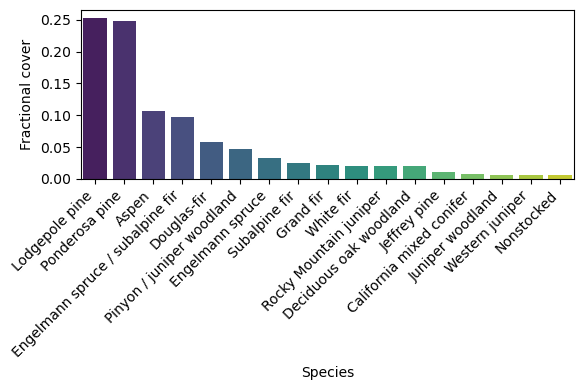

220

In [7]:
# Create a histogram of the forest species (prevalence)
fortyp = grid_fortypcd.copy() # make a copy to work with
fortyp = fortyp[fortyp['count'] > 0] # make sure there are some pixels
# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('fortypnm')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.99]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# clean up
del fortyp, spp_pr
gc.collect()

In [8]:
# drop out plots with california species or nonstocked
drop_spps = ['Jeffrey pine', 'California mixed conifer', 
             'Juniper woodland', 'Western juniper', 
             'Nonstocked', 'Grand fir', 
            ]
grid_fortypcd_ = grid_fortypcd[~grid_fortypcd['fortypnm'].isin(drop_spps)]

# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
# spp_grouping = {
#     'pinyon|juniper': 'Piñon-juniper',
#     'engelmann spruce|subalpine fir': 'Spruce-fir',
#     'ponderosa pine|jeffrey': 'Ponderosa', 
#     'lodgepole pine': 'Lodgepole',
#     'aspen': 'Aspen',
#     'douglas-fir|grand fir|white fir': 'Mixed-conifer',
#     'oak': 'Oak-woodland',
# }

# Alternate option
spp_grouping = {
    'Pinyon / juniper woodland|Rocky Mountain juniper': 'Piñon-juniper',
    'engelmann spruce|subalpine fir': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole',
    'Aspen': 'Quaking aspen',
    'douglas-fir|white fir': 'Mixed-conifer',
    'Deciduous oak woodland': 'Oak-woodland',
    'Cottonwood|Willow|Cottonwood / willow': 'Riparian'
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_fortypcd_[grid_fortypcd_['fortypnm'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['fortypnm'].unique()}
    )
    del spp
    
# Apply the remap to create a new grouped species column
grid_fortypcd_['fortypnm_gp'] = grid_fortypcd_['fortypnm'].map(spp_remap).fillna(grid_fortypcd_['fortypnm'])
# Verify the updated species groups
print(grid_fortypcd_[['fortypnm', 'fortypnm_gp']].drop_duplicates().head(3))
print(f"\n{grid_fortypcd_.columns}")

                 fortypnm    fortypnm_gp
0  Rocky Mountain juniper  Piñon-juniper
1             Douglas-fir  Mixed-conifer
2          Ponderosa pine      Ponderosa

Index(['grid_index', 'fortypcd', 'count', 'total_pixels', 'pct_cover',
       'fortypnm', 'fortypnm_gp'],
      dtype='object')


In [9]:
# Aggregate with the new species groupings
# Reacalculate the percent cover for each species group
grid_fortypgp = (
    grid_fortypcd_.groupby(['grid_index','fortypnm_gp'], as_index=False)
    .agg(
        count=('count','sum'),
        total_pixels=('total_pixels','max'),
        pct_cover=('pct_cover','sum'),
    )
)

# Merge in the forest percent
grid_fortypgp = grid_fortypgp.merge(forest_pct, on='grid_index', how='inner')

# Check on nulls introduced
print(f"\nNaNs in FORTYP group name: {grid_fortypgp['fortypnm_gp'].isna().sum()}\n")
print(f"Forest percent:\n{grid_fortypgp['forest_pct'].describe()}\n")
print(f"\n{grid_fortypgp.head(10)}\n")
print("\n~~~~~~~~~~~~~~~~~~\n")

# del grid_fortypcd, grid_fortypcd_, forest_pct
# gc.collect()


NaNs in FORTYP group name: 0

Forest percent:
count    233883.000000
mean         84.588174
std          23.635002
min           0.510204
25%          78.571429
50%          97.041420
75%         100.000000
max         100.000000
Name: forest_pct, dtype: float64


   grid_index      fortypnm_gp  count  total_pixels  pct_cover  forest_pixels  \
0       34602  Other hardwoods      1           181   0.552486            182   
1       34602    Piñon-juniper    148           181  81.767956            182   
2       34602        Ponderosa     32           181  17.679558            182   
3       34603     Oak-woodland      4           167   2.395210            169   
4       34603  Other hardwoods      3           167   1.796407            169   
5       34603    Piñon-juniper     95           167  56.886228            169   
6       34603        Ponderosa     64           167  38.323353            169   
7       34603    Quaking aspen      1           167   0.598802            169   
8    

In [10]:
# check for duplicates, remove them
n = grid_fortypgp.duplicated(subset=['grid_index','fortypnm_gp','pct_cover']).sum()
if n > 0:
    print(f"\nDropping [{n}] duplicate rows.\n")
    grid_fortypgp = grid_fortypgp.drop_duplicates(subset=['grid_index','fortypnm_gp','pct_cover'])
else:
    print("\nNo duplicates at this stage.\n")


Dropping [1562] duplicate rows.





Species making up 97% of the total: 

      fortypnm_gp    count  fraction  dom_count  dom_fraction  c_fraction
16      Lodgepole  2101831  0.268480    12068.0      0.223523    0.268480
30      Ponderosa  2066006  0.263904    12733.0      0.235840    0.532384
37     Spruce-fir  1292501  0.165099     6964.0      0.128987    0.697483
31  Quaking aspen   888731  0.113523     4033.0      0.074699    0.811006
20  Mixed-conifer   652909  0.083400     1374.0      0.025449    0.894406
29  Piñon-juniper   565103  0.072184     2713.0      0.050250    0.966590




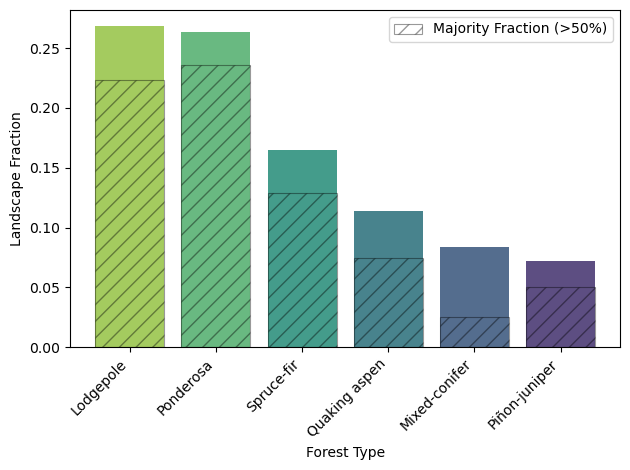

10830

In [11]:
# Re-create the histogram of forest species (prevalence)
df = grid_fortypgp.copy() # make a copy to work with
# calculate the landscape fraction (prevalence)
spp_pr = df.groupby('fortypnm_gp')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()

# How many grids have a majority by each species?
dom_grids = df[df['pct_cover'] > 50]  # Grids dominated by each species
dom_counts = dom_grids.groupby('fortypnm_gp')['grid_index'].nunique().reset_index()
dom_counts.rename(columns={'grid_index': 'dom_count'}, inplace=True)
# Total grid count for normalization
total_grids = df['grid_index'].nunique()
dom_counts['dom_fraction'] = dom_counts['dom_count'] / total_grids

# Merge the dominance fraction into the species prevalence table
spp_pr = spp_pr.merge(dom_counts, on='fortypnm_gp', how='left').fillna(0)
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# Plot the landscape fraction as bars
bar_width = 0.8
sns.barplot(
    data=top_species, 
    x='fortypnm_gp', 
    y='fraction', 
    palette='viridis_r', 
    alpha=0.9)

# Overlay the dominance fraction as cross-hatched bars
for i, species in enumerate(top_species['fortypnm_gp']):
    dom_value = top_species[top_species['fortypnm_gp'] == species]['dom_fraction'].values[0]
    plt.bar(
        x=i,
        height=dom_value,
        color='none',
        edgecolor='black',
        hatch='//',
        width=bar_width,
        alpha=0.4,
        linewidth=0.8,
        label='Majority Fraction (>50%)' if i == 0 else None,  
    )

# Add labels and formatting
plt.xlabel('Forest Type')
plt.ylabel('Landscape Fraction')
plt.xticks(ticks=range(len(top_species)), labels=top_species['fortypnm_gp'], rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()

# Save the map
out_png = os.path.join(projdir, 'figures/FigureS1_TopSpecies_97pct.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

del df, spp_pr # tidy up
gc.collect()

In [12]:
# Get the species co-occurrence percentages
spps = top_species['fortypnm_gp'].unique()
coo = get_spp_coo(grid_fortypgp, spps) # see '__functions.py')
print(f"\n{coo.head(30)}\n")


Species occurrence counts:
fortypnm_gp
Ponderosa        36902
Lodgepole        35505
Quaking aspen    30682
Mixed-conifer    29415
Piñon-juniper    27036
Spruce-fir       26089
Name: count, dtype: int64


                      species_pair  coo_count    coo_pct
13      (lodgepole, quaking aspen)      25639  47.531562
4       (mixed-conifer, ponderosa)      25322  46.943883
0       (piñon-juniper, ponderosa)      24958  46.269072
14         (lodgepole, spruce-fir)      22733  42.144195
12          (lodgepole, ponderosa)      21787  40.390427
10      (lodgepole, mixed-conifer)      21297  39.482027
2       (ponderosa, quaking aspen)      21176  39.257707
5   (mixed-conifer, quaking aspen)      20800  38.560650
9      (quaking aspen, spruce-fir)      19121  35.447989
3   (mixed-conifer, piñon-juniper)      17529  32.496617
11      (lodgepole, piñon-juniper)      13625  25.259079
6      (mixed-conifer, spruce-fir)      13510  25.045883
1   (piñon-juniper, quaking aspen)      13150  24.378

In [13]:
# check on all the species remaining
grid_fortypgp['fortypnm_gp'].unique()

array(['Other hardwoods', 'Piñon-juniper', 'Ponderosa', 'Oak-woodland',
       'Quaking aspen', 'Bur oak', 'Mixed-conifer',
       'Eastern redcedar / hardwood', 'Riparian',
       'Sugarberry / hackberry / elm / green ash',
       'Elm / ash / black locust', 'Western redcedar',
       'Mesquite woodland', 'Other exotic hardwoods', 'Spruce-fir',
       'Lodgepole', 'Cercocarpus (mountain brush) woodland',
       'Intermountain maple woodland', 'Western larch', 'Blue spruce',
       'Limber pine', 'Balsam fir', 'Foxtail pine / bristlecone pine',
       'Paper birch', 'Miscellaneous western softwoods', 'Noble fir',
       'Sugar maple / beech / yellow birch', 'Hard maple / basswood',
       'Evergreen oak woodland', 'Southwestern white pine', 'Red alder',
       'California black oak', 'White spruce', 'Mountain hemlock',
       'Canyon live oak', 'Sugar pine',
       'California white oak (valley oak)', 'Pin cherry',
       'Whitebark pine', 'Miscellaneous woodland hardwoods',
       'Ea

In [14]:
# subset to known species
print(f'\n{len(grid_fortypgp)}/n')
grid_fortypgp = grid_fortypgp[grid_fortypgp['fortypnm_gp'].isin(spps)]
print(f'\n{len(grid_fortypgp)}/n')


232321/n

185629/n


In [15]:
# save the TreeMap FORTYPCD table out.
out_fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypnm_gp.csv')
grid_fortypgp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypnm_gp.csv


In [14]:
# subset the grids to predominantly forested plots (>50% forested)
# Just work with forested grids from here on out:
grid_forest = grid_fortypgp[grid_fortypgp['forest_pct'] > 50]
n_forest = len(grid_forest['grid_index'].unique())
print(f"{n_forest}/{len(grid)} [{round(n_forest/len(grid)*100,1)}%] gridcells are >50% forested.")

46708/54747 [85.3%] gridcells are >50% forested.


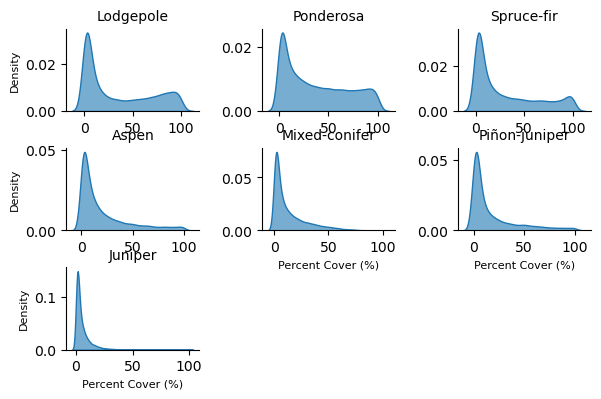

In [15]:
# plot the distribution of percent cover by forest types
df = grid_fortypgp.copy()
df['fortypnm_gp'] = df['fortypnm_gp'].astype('category')
species_order = top_species['fortypnm_gp'].tolist()
df['fortypnm_gp'] = pd.Categorical(
    df['fortypnm_gp'],
    categories=species_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=df,
    col='fortypnm_gp',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'pct_cover', fill=True, alpha=0.6)
# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Percent Cover (%)", "Density", size=8)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

del df
gc.collect()

plt.show()

In [16]:
grid_fortypgp.columns

Index(['grid_index', 'fortypnm_gp', 'count', 'total_pixels', 'pct_cover',
       'forest_pixels', 'forest_pct'],
      dtype='object')

In [17]:
grid_fortypgp['fortypnm_gp'].isna().sum()

0

In [18]:
print(len(grid_fortypgp))
print(len(grid))

244061
54747


In [19]:
# join the forest type dataframe to our FRP gridcells
grid_frp = grid.merge(grid_fortypgp, on='grid_index', how='inner')
print(grid_frp.columns)
print(len(grid_frp))

# tidy up
del grid_forest
gc.collect()

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y', 'fortypnm_gp', 'count', 'total_pixels', 'pct_cover',
       'forest_pixels', 'forest_pct'],
      dtype='object')
245700


0

In [20]:
print(f"\nDropping [{grid_frp['fortypnm_gp'].isna().sum()}] NaN rows.\n")
grid_frp = grid_frp[~grid_frp['fortypnm_gp'].isna()]
print(len(grid_frp))


Dropping [0] NaN rows.

245700


In [21]:
print(f"\nSubsetting to top species groups:\n{top_species['fortypnm_gp'].unique()}")
grid_frp = grid_frp[grid_frp['fortypnm_gp'].isin(top_species['fortypnm_gp'].unique())]
print(f"\n{len(grid_frp['grid_index'].unique())}/{len(grid['grid_index'].unique())}")


Subsetting to top species groups:
['Lodgepole' 'Ponderosa' 'Spruce-fir' 'Aspen' 'Mixed-conifer'
 'Piñon-juniper' 'Juniper']

53941/54365


['Piñon-juniper' 'Ponderosa' 'Aspen' 'Mixed-conifer' 'Lodgepole'
 'Spruce-fir' 'Juniper']


Dropping 11182 [20.7%] gridcells w/ >0 max daytime FRP.


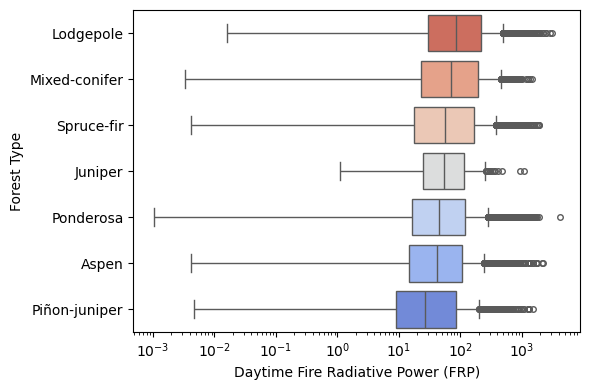


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_gp.png



In [22]:
# make some plots showing the distribution of FRP across forest types
# gather the dominant forest type
dfortyp = grid_frp.loc[grid_frp.groupby('grid_index')['pct_cover'].idxmax()]
print(dfortyp['fortypnm_gp'].unique())
print("\n")

# Retain only the daytime FRP measurements
n_small = len(dfortyp[dfortyp['frp_max_day'] == 0]) 
print(f"Dropping {n_small} [{round(n_small/len(dfortyp)*100,1)}%] gridcells w/ >0 max daytime FRP.")
dfortyp = dfortyp[(dfortyp['frp_max_day'] > 0)]

# create a dataframe with dominance (>90% of the same species)
dom = dfortyp[dfortyp['pct_cover'] > 50]
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = dom.groupby('fortypnm_gp')['frp_max_day'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# setup the plot
plt.figure(figsize=(6, 4)) 

# boxplot
sns.boxplot(
    data=dom, 
    x='frp_max_day', 
    y='fortypnm_gp', 
    order=sorted, 
    palette='coolwarm_r', 
    fliersize=4,
    dodge=False)

# adjust plot elements
plt.xscale('log') # log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')
plt.tight_layout()
# save it out.
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [20]:
# Run a statistical test between these groups
from scipy.stats import kruskal
import scikit_posthocs as sp

# Group FRP by forest type
grouped_frp = [dom[dom['fortypnm_gp'] == f]['frp_max_day'].values for f in sorted]
# Perform Kruskal-Wallis test
stat, p = kruskal(*grouped_frp)
print(f"\nKruskal-Wallis Test: H={stat:.3f}, p={p:.3e}\n")

# Dunn's test for pairwise comparisons
dunn = sp.posthoc_dunn(
    dom, val_col='frp_max_day', group_col='fortypnm_gp', p_adjust='bonferroni'
)
print(f"Dunn's test:\n{dunn}")
print("\n~~~~~~~~~~~~~~~~~\n")

del grouped_frp, stat, p, dunn
gc.collect()


Kruskal-Wallis Test: H=786.827, p=8.184e-168

Dunn's test:
                      Aspen      Lodgepole  Mixed-conifer  Piñon-juniper  \
Aspen          1.000000e+00   1.549324e-68   2.522440e-11   3.369501e-01   
Lodgepole      1.549324e-68   1.000000e+00   1.000000e+00   1.373972e-76   
Mixed-conifer  2.522440e-11   1.000000e+00   1.000000e+00   1.617883e-15   
Piñon-juniper  3.369501e-01   1.373972e-76   1.617883e-15   1.000000e+00   
Ponderosa      1.732920e-05  1.980835e-100   3.517122e-06   1.055426e-11   
Spruce-fir     2.404470e-11   8.660647e-44   2.618460e-03   1.561001e-18   

                   Ponderosa    Spruce-fir  
Aspen           1.732920e-05  2.404470e-11  
Lodgepole      1.980835e-100  8.660647e-44  
Mixed-conifer   3.517122e-06  2.618460e-03  
Piñon-juniper   1.055426e-11  1.561001e-18  
Ponderosa       1.000000e+00  2.450601e-03  
Spruce-fir      2.450601e-03  1.000000e+00  

~~~~~~~~~~~~~~~~~



6158

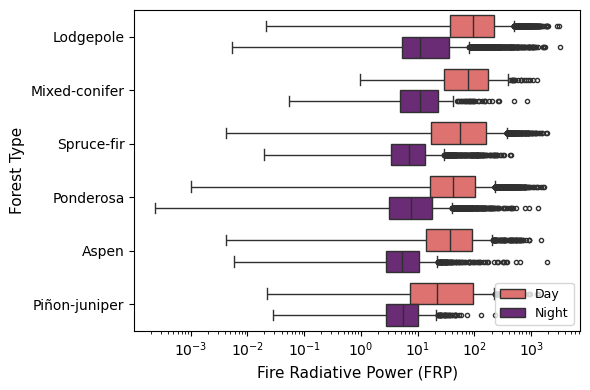


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight_gp.png



In [21]:
# Plot the Day vs. Night max FRP for dominant types
dom = dom[dom['frp_max_day'] > 0]
dom = dom[dom['frp_max_night'] > 0]

# Reshape the data to long format for both day and night FRP
dom_l = pd.melt(
    dom, 
    id_vars=['fortypnm_gp'], 
    value_vars=['frp_max_day', 'frp_max_night'], 
    var_name='DayNight', 
    value_name='FRP'
)

# Map `Time` values for clearer labels
dom_l['DayNight'] = dom_l['DayNight'].map({
    'frp_max_day': 'Day', 
    'frp_max_night': 'Night'
})

# Create the plot
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=dom_l,
    x="FRP",
    y="fortypnm_gp",
    hue="DayNight",
    order=sorted,
    palette='magma_r',
    fliersize=3,
)

plt.xscale('log')  # Log-scale FRP
plt.xlabel('Fire Radiative Power (FRP)', fontsize=11)
plt.ylabel('Forest Type', fontsize=11)
plt.legend(title='', loc='lower right', fontsize=9)
plt.tight_layout()

# Save and show the plot
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved to: {out_plot}\n")

In [22]:
# save the table out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_fortypnm_gp_forest_frp.csv')
grid_forest_frp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_fortypnm_gp_forest_frp.csv


In [23]:
# Identify gridcells with some aspen component
aspen_idx = grid_forest_frp[grid_forest_frp['fortypnm_gp'] == 'Aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_forest_frp[grid_forest_frp['grid_index'].isin(aspen_idx)]
# check how many aspen gridcells there are
n_aspen = len(grid_aspen['grid_index'].unique())
print(f"{n_aspen} [{round(n_aspen/len(grid_forest_frp['grid_index'].unique())*100,1)}%] gridcells with some aspen component.")

27136 [58.1%] gridcells with some aspen component.


Associate forest type: ['Lodgepole', 'Mixed-conifer', 'Piñon-juniper', 'Ponderosa', 'Spruce-fir']



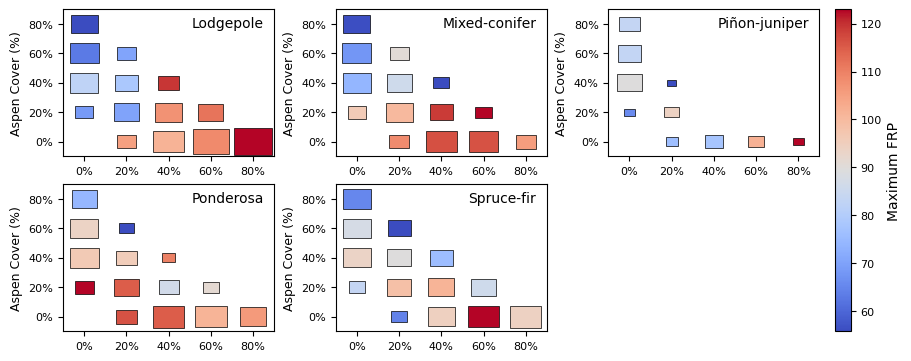

In [24]:
# waffle chart version
# create bins for species composition
bins = np.linspace(0, 100, 6) # 20% intervals
spps = [s for s in grid_aspen['fortypnm_gp'].unique() if s != 'Aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

# create grid data
df = grid_aspen.copy() # work from a copy
tiles = []  # Store tile data
for sp in spps:
    # Filter for co-occurrence
    df_sp = df[df['fortypnm_gp'].isin(['Aspen', sp])]
    # Pivot to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(
            index='grid_index', 
            columns='fortypnm_gp', 
            values='pct_cover', 
            fill_value=0
        ).reset_index()
         .rename(columns={'Aspen': 'aspen_cover', sp: f'{sp}_cover'})
    )
    # Make sure there are some of each species (aspen and other)
    cover_df['combined_cover'] = cover_df['aspen_cover'] + cover_df[f'{sp}_cover']
    cover_df = cover_df[cover_df['combined_cover'] >= 50] # where one or both make up the majority
    # Merge back with FRP data
    cover_df = cover_df.merge(
        grid_aspen[['grid_index','frp_max_day', 'frp_max_night']].drop_duplicates(), 
        on='grid_index', how='left')

    # Bin Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_cover'], bins, labels=range(len(bins) - 1))
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_cover'], bins, labels=range(len(bins) - 1))
    # Group by bins and calculate statistics
    grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
    counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
    mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

    # Merge statistics into a single DataFrame
    tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
    tiled_data['species'] = sp
    tiles.append(tiled_data)

    # Tidy up
    del df_sp, cover_df, grouped, counts, mean_frp, tiled_data
    gc.collect()

# Combine tile data
tiles_df = pd.concat(tiles, ignore_index=True)
tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1e-6) # add a small value to help with log-scaling

# Normalize tile sizes (scale frequency)
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# Plotting the tile-scaled heatmap
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(len(spps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,3.5), constrained_layout=True)
axes = axes.flatten()

# handle the normalization
vmin = tiles_df['log_frp'].min()
vmax = tiles_df['log_frp'].quantile()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# log_frp_min = np.percentile(tiles_df['log_frp'], 10)
# log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# make the grids
for i, sp in enumerate(spps):
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax = axes[i]

    vmin = sp_data['frp'].min()
    vmax = sp_data['frp'].max()

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])  
        y = int(row['aspen_bin'])  
        size = row['tile_size'] * 0.9
        
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        color = plt.cm.coolwarm(norm(row['frp']))
        
        ax.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting the axes
    # ax.set_title(sp, size=10)
    ax.text(
        0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
        transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
        ha='right', va='top',  # Align the text to the top-right
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax.set_xlabel(f'')
    ax.set_ylabel('Aspen Cover (%)', size=9)
    ax.set_xticks(range(len(bins) - 1))
    ax.set_yticks(range(len(bins) - 1))
    ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_xlim(-0.5, len(bins) - 1.5)
    ax.set_ylim(-0.5, len(bins) - 1.5)

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('Maximum FRP')
# cbar.set_label('Cumulative FRP', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [25]:
gc.collect()

25